## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [4]:
tmp = np.load('eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [5]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [6]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [7]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.7398, Test Loss: 0.7097
Epoch 2/200, Loss: 0.5665, Test Loss: 0.5979
Epoch 3/200, Loss: 0.4890, Test Loss: 0.5499
Epoch 4/200, Loss: 0.4425, Test Loss: 0.5636
Epoch 5/200, Loss: 0.4228, Test Loss: 0.5374
Epoch 6/200, Loss: 0.3917, Test Loss: 0.5471
Epoch 7/200, Loss: 0.3960, Test Loss: 0.5097
Epoch 8/200, Loss: 0.3768, Test Loss: 0.5433
Epoch 9/200, Loss: 0.3880, Test Loss: 0.5395
Epoch 10/200, Loss: 0.3820, Test Loss: 0.5630
Epoch 11/200, Loss: 0.3593, Test Loss: 0.5191
Epoch 12/200, Loss: 0.3571, Test Loss: 0.4970
Epoch 13/200, Loss: 0.3576, Test Loss: 0.5293
Epoch 14/200, Loss: 0.3632, Test Loss: 0.5457
Epoch 15/200, Loss: 0.3408, Test Loss: 0.5272
Epoch 16/200, Loss: 0.3488, Test Loss: 0.5527
Epoch 17/200, Loss: 0.3416, Test Loss: 0.5084
Epoch 18/200, Loss: 0.3355, Test Loss: 0.5274
Epoch 19/200, Loss: 0.3322, Test Loss: 0.5014
Epoch 20/200, Loss: 0.3357, Test Loss: 0.4884
Epoch 21/200, Loss: 0.3305, Test Loss: 0.4857
Epoch 22/200, Loss: 0.3304, Test Loss: 0.49

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

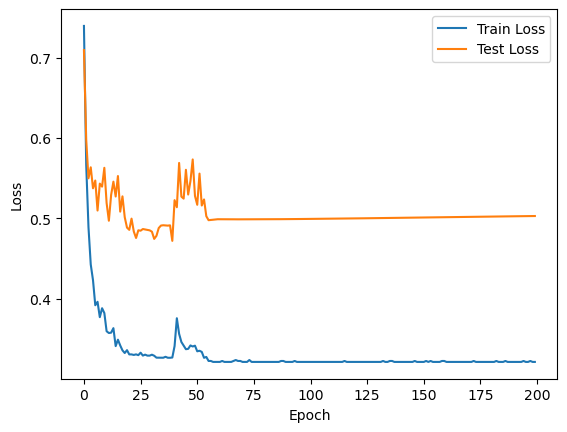

In [9]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [10]:
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"minimum train loss: {min_train_loss}\nminimum test loss: {min_test_loss}")

minimum train loss: 0.32107508927583694
minimum test loss: 0.471935639778773


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [11]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOW
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        # INSERT CODE BELOW
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.dropout3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [13]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2) 

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6871, Test Loss: 0.7106
Epoch 2/200, Loss: 0.5884, Test Loss: 0.6952
Epoch 3/200, Loss: 0.5275, Test Loss: 0.6770
Epoch 4/200, Loss: 0.5014, Test Loss: 0.6566
Epoch 5/200, Loss: 0.4926, Test Loss: 0.6538
Epoch 6/200, Loss: 0.4586, Test Loss: 0.6310
Epoch 7/200, Loss: 0.4351, Test Loss: 0.6070
Epoch 8/200, Loss: 0.4301, Test Loss: 0.5801
Epoch 9/200, Loss: 0.4481, Test Loss: 0.6195
Epoch 10/200, Loss: 0.4208, Test Loss: 0.6749
Epoch 11/200, Loss: 0.4177, Test Loss: 0.5767
Epoch 12/200, Loss: 0.3900, Test Loss: 0.5796
Epoch 13/200, Loss: 0.4103, Test Loss: 0.5977
Epoch 14/200, Loss: 0.4060, Test Loss: 0.5798
Epoch 15/200, Loss: 0.3753, Test Loss: 0.5884
Epoch 16/200, Loss: 0.3944, Test Loss: 0.5648
Epoch 17/200, Loss: 0.3833, Test Loss: 0.5356
Epoch 18/200, Loss: 0.3928, Test Loss: 0.5445
Epoch 19/200, Loss: 0.3563, Test Loss: 0.5253
Epoch 20/200, Loss: 0.3692, Test Loss: 0.5655
Epoch 21/200, Loss: 0.3666, Test Loss: 0.5407
Epoch 22/200, Loss: 0.3602, Test Loss: 0.54

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

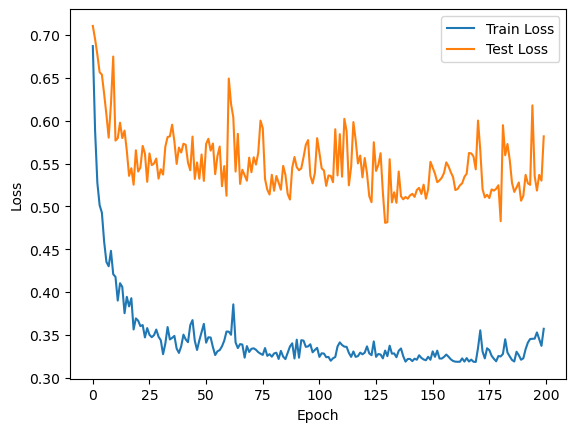

In [14]:
# INSERT CODE HERE
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [15]:
# INSERT CODE HERE  
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"minimum train loss: {min_train_loss}\nminimum test loss: {min_test_loss}")

minimum train loss: 0.3184211055437724
minimum test loss: 0.48073004682858783


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [16]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7137, Test Loss: 0.7043
Epoch 2/200, Loss: 0.6777, Test Loss: 0.6613
Epoch 3/200, Loss: 0.6317, Test Loss: 0.6385
Epoch 4/200, Loss: 0.6033, Test Loss: 0.6395
Epoch 5/200, Loss: 0.5874, Test Loss: 0.5967
Epoch 6/200, Loss: 0.5695, Test Loss: 0.6007
Epoch 7/200, Loss: 0.5359, Test Loss: 0.5578
Epoch 8/200, Loss: 0.5295, Test Loss: 0.5772
Epoch 9/200, Loss: 0.5265, Test Loss: 0.5544
Epoch 10/200, Loss: 0.5097, Test Loss: 0.5495
Epoch 11/200, Loss: 0.5006, Test Loss: 0.5446
Epoch 12/200, Loss: 0.4819, Test Loss: 0.5719
Epoch 13/200, Loss: 0.4854, Test Loss: 0.5478
Epoch 14/200, Loss: 0.4615, Test Loss: 0.5458
Epoch 15/200, Loss: 0.4602, Test Loss: 0.5233
Epoch 16/200, Loss: 0.4535, Test Loss: 0.5280
Epoch 17/200, Loss: 0.4646, Test Loss: 0.5594
Epoch 18/200, Loss: 0.4786, Test Loss: 0.5167
Epoch 19/200, Loss: 0.4682, Test Loss: 0.5260
Epoch 20/200, Loss: 0.4605, Test Loss: 0.5210
Epoch 21/200, Loss: 0.4416, Test Loss: 0.5152
Epoch 22/200, Loss: 0.4391, Test Loss: 0.50

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

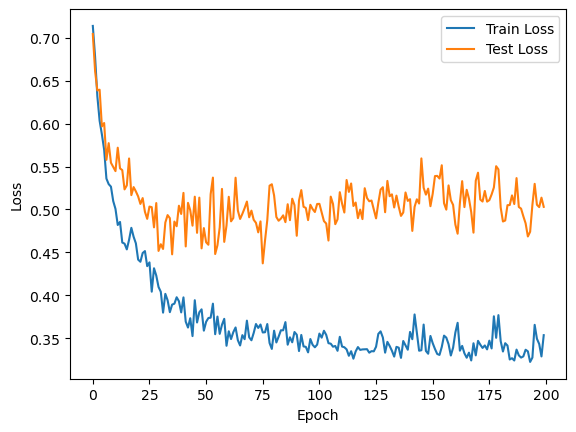

In [17]:
# INSERT CODE HERE
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [18]:
# INSERT CODE HERE
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"minimum train loss: {min_train_loss}\nminimum test loss: {min_test_loss}")


minimum train loss: 0.32240916043519974
minimum test loss: 0.4372013012568156


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7849, Test Loss: 0.7086
Epoch 2/200, Loss: 0.7858, Test Loss: 0.7403
Epoch 3/200, Loss: 0.7676, Test Loss: 0.7381
Epoch 4/200, Loss: 0.7763, Test Loss: 0.7200
Epoch 5/200, Loss: 0.8417, Test Loss: 0.6935
Epoch 6/200, Loss: 0.8002, Test Loss: 0.6826
Epoch 7/200, Loss: 0.7740, Test Loss: 0.6784
Epoch 8/200, Loss: 0.7829, Test Loss: 0.6745
Epoch 9/200, Loss: 0.8084, Test Loss: 0.6799
Epoch 10/200, Loss: 0.7717, Test Loss: 0.6852
Epoch 11/200, Loss: 0.7861, Test Loss: 0.6962
Epoch 12/200, Loss: 0.7920, Test Loss: 0.6898
Epoch 13/200, Loss: 0.8189, Test Loss: 0.6874
Epoch 14/200, Loss: 0.7643, Test Loss: 0.6916
Epoch 15/200, Loss: 0.7464, Test Loss: 0.6944
Epoch 16/200, Loss: 0.7681, Test Loss: 0.6915
Epoch 17/200, Loss: 0.8069, Test Loss: 0.6808
Epoch 18/200, Loss: 0.7648, Test Loss: 0.6674
Epoch 19/200, Loss: 0.7427, Test Loss: 0.6643
Epoch 20/200, Loss: 0.7589, Test Loss: 0.6645
Epoch 21/200, Loss: 0.7448, Test Loss: 0.6671
Epoch 22/200, Loss: 0.6872, Test Loss: 0.66

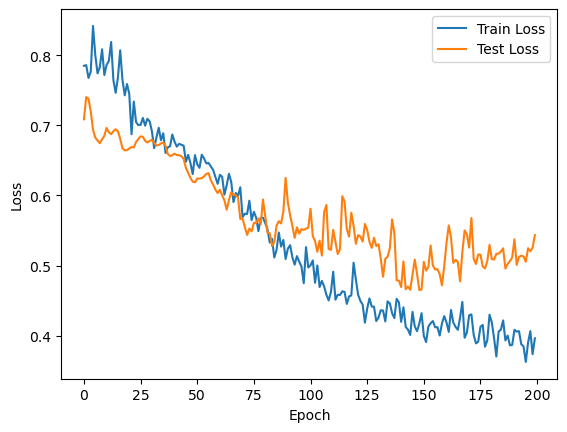

minimum train loss: 0.36262843757867813
minimum test loss: 0.4650990863641103


In [19]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

plt.plot(range(200), train_losses, label='Train Loss')
plt.plot(range(200), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"minimum train loss: {min_train_loss}\nminimum test loss: {min_test_loss}")



In [ ]:
# As the dropout rate increases, the train loss tends to increase and the test loss tends to decrease. This is because the model is less likely to overfit the training data as the dropout rate increases. However, this prevents the model from learning anything (gives it a "short term memory"). 